In [40]:
import requests
from tqdm import tqdm
from requests.auth import HTTPBasicAuth
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from matplotlib import rcParams
import matplotlib.patches as pat

from PIL import Image
import urllib
import matplotlib.font_manager as fm
from matplotlib.patches import Arc
from highlight_text import fig_text

import numpy as np

import os

username = 'qjpuw3t-yf3bvhgms-8d0gift-bm2fprvs4z'
token =  '7*.w$Ivko$FpRsbumn0gF(0Kc5yMAI'

base_url = 'https://apirest.wyscout.com/v3{}'

pitch_size_lenght = 105
pitch_size_width = 68


In [76]:
font_path = "../Fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f'{font_path}/{x}'):
        if y.split('.')[-1] == 'ttf':
            fm.fontManager.addfont(f'{font_path}/{x}/{y}')
            try:
                fm.FontProperties(weight=y.split('-')[-1].split('.')[0].lower(), fname=y)
            except Exception as e:
                print(f'Font {y} could not be added.')
                continue

rcParams['font.family'] = 'DMSans-Regular'

Font DMSans-BoldItalic.ttf could not be added.
Font DMSans-Italic.ttf could not be added.
Font DMSans-MediumItalic.ttf could not be added.
Font DmSansBold-eZ5xm.ttf could not be added.
Font DmSansBoldItalic-Wy01n.ttf could not be added.
Font DmSansItalic-axW0K.ttf could not be added.
Font DmSansMedium-Ea9KW.ttf could not be added.
Font DmSansMediumItalic-OVw36.ttf could not be added.
Font DmSansRegular-ZVWM3.ttf could not be added.
Font Karla-BoldItalic.ttf could not be added.
Font Karla-Italic.ttf could not be added.


Players, Teams

In [43]:
SerieA = 524

A_Season_21_22 = 187528
A_Season_20_21 = 186353
A_Season_19_20 = 186353
A_Season_22_23 = 188160

FiorentinaId = 3176
JuvenstusID = 3159
available_seasons = [(SerieA,A_Season_22_23)]

players,teams = [],[]
players_season = {}

for season in available_seasons:
    api_url = base_url.format(f'/seasons/{season[1]}/teams')
    response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
    if response.ok:
        team = response.json()['teams']
        teams+=team

team_name = {}
for team in teams:
  team_name[team['wyId']] = team['name']

match events V3

In [44]:
events = []
matches = []

teamId = JuvenstusID
for season in available_seasons:
    
    api_url = base_url.format(f'/teams/{teamId}/matches?seasonId={season[1]}')
    response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
    if response.ok:
      season_matches = response.json()['matches']
    else:
      print("errore")
      break
    for m in tqdm(season_matches):
        api_url = base_url.format('/matches/%s/events'%(m['matchId']))
        response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
        if response.ok:
            match_events = response.json()['events']
            events += match_events

        
        api_url = base_url.format('/matches/%s'%(m['matchId']))
        response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
        if response.ok:
            matches.append( response.json())

    for team in team_name.keys():
      api_url = base_url.format(f'/teams/{team}/squad?seasonId={season[1]}')
      response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
      if response.ok:
        player = response.json()['squad']
        players+=player
      for p in player:
          players_season[p['wyId']] = season

player_name = {}
for p in players:
  player_name[p['wyId']] = [p['shortName'], p['role']['code3']]

team_name = {}
for t in teams:
  team_name[t['wyId']] = t['name']

match_name = {}
for m in matches:
  match_name[m['wyId']] = m['label']

100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


In [45]:
team_lineup = matches[0]['teamsData'][str(teamId)]['formation']['lineup']
lineup_list = []
for player in team_lineup:
    lineup_list.append(player['playerId'])

In [46]:
pass_loc = []

for i,ev in enumerate(events):
  if (ev['type']['primary']=='pass'):
    doc1 = {}
    doc1['eventId'] = ev['id']
    doc1['player'] = player_name[ev['player']['id']][0] if ev['player']['id'] in player_name.keys() else "A. Rabiot"
    doc1['playerId'] = ev['player']['id']
    doc1['role'] =  player_name[ev['player']['id']][1] if ev['player']['id'] in player_name.keys() else "MF"
    doc1['match'] = match_name[ev['matchId']]
    doc1['period'] = ev['matchPeriod']
    doc1['team'] = team_name[ev['team']['id']]
    doc1['type_primary'] = ev['type']['primary']
    doc1['type_secondary'] = ev['type']['secondary']
    doc1['pass_accurate'] = ev['pass']['accurate']
    doc1['pass_length'] = ev['pass']['length']
    doc1['pass_angle'] = ev['pass']['angle']
    doc1['pass_recipientId'] = ev['pass']['recipient']['id']
    doc1['fromX'] = ev['location']['x']
    doc1['fromY'] = ev['location']['y']
    doc1['toX'] = ev['pass']['endLocation']['x']
    doc1['toY'] = ev['pass']['endLocation']['y']

    pass_loc.append(doc1)

pass_df = pd.DataFrame(pass_loc)

Formazione iniziale

In [47]:
pass_SAM_JUV_df  = pass_df[pass_df.match == 'Sampdoria - Juventus, 0 - 0']
pass_team_df = pass_SAM_JUV_df[pass_SAM_JUV_df.playerId.isin(lineup_list)]

In [48]:
pass_team_df["fromXm"] = round((pass_team_df["fromY"]*pitch_size_width/100),1)
pass_team_df["fromYm"] = round((pass_team_df["fromX"]*pitch_size_lenght/100),1)
pass_team_df["toXm"] = round((pass_team_df["toY"]*pitch_size_width/100),1)
pass_team_df["toYm"] = round((pass_team_df["toX"]*pitch_size_lenght/100),1)

C:\Users\fgron\AppData\Local\Temp\ipykernel_15080\1745732701.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_team_df["fromXm"] = round((pass_team_df["fromY"]*pitch_size_width/100),1)
C:\Users\fgron\AppData\Local\Temp\ipykernel_15080\1745732701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_team_df["fromYm"] = round((pass_team_df["fromX"]*pitch_size_lenght/100),1)
C:\Users\fgron\AppData\Local\Temp\ipykernel_15080\1745732701.py:3: SettingWithCopyWarning: 
A value is trying to be set on a co

In [49]:
pass_position = pass_team_df.groupby(['playerId'],as_index=False)
pass_position = pass_position.agg({'fromXm': 'mean','fromYm': 'mean'})

team_players = pass_SAM_JUV_df[['playerId', 'player']]

pass_position = pd.merge(pass_position, team_players, on='playerId')
accurate_pass_team_df = pass_team_df[pass_team_df.pass_accurate==True]

accurate_pass_team_df['distance'] = np.sqrt((abs(accurate_pass_team_df['toXm'] - accurate_pass_team_df['fromXm']) ** 2 + abs(accurate_pass_team_df['toYm'] - accurate_pass_team_df['fromYm']) ** 2).values)

C:\Users\fgron\AppData\Local\Temp\ipykernel_15080\2591173905.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accurate_pass_team_df['distance'] = np.sqrt((abs(accurate_pass_team_df['toXm'] - accurate_pass_team_df['fromXm']) ** 2 + abs(accurate_pass_team_df['toYm'] - accurate_pass_team_df['fromYm']) ** 2).values)


In [50]:
from numpy import linalg as LA

def calc_degree(fromX, fromY, toX, toY):
  u = np.array([toX - fromX, pitch_size_lenght - fromY])
  v = np.array([toX - fromX, toY - fromY])
  i = np.inner(u, v)
  n = LA.norm(u) * LA.norm(v)
  c = i / n
  a = np.rad2deg(np.arccos(np.clip(c, -1.0, 1.0)))
  if toX - fromX < 0:
    a = 360 - a
  return a

def calc_pass_theta(row):
  return round(
    calc_degree(
      row['fromXm']
      ,row['fromYm']
      ,row['toXm']
      ,row['toYm']
    )
  )
#Apply function each row
accurate_pass_team_df['angle'] = accurate_pass_team_df.apply(calc_pass_theta  ,axis=1)

C:\Users\fgron\AppData\Local\Temp\ipykernel_15080\962495873.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accurate_pass_team_df['angle'] = accurate_pass_team_df.apply(calc_pass_theta  ,axis=1)


In [51]:
def divide(angle, divisions):
  degree = 360 / divisions
  division = ((angle + (degree / 2)) // degree) + 1
  if division > angle:
    division = 1
  return division

def divide_pass_direction(row):
  return divide(row['angle'],8)

accurate_pass_team_df['direction'] = accurate_pass_team_df.apply(divide_pass_direction,axis=1)

C:\Users\fgron\AppData\Local\Temp\ipykernel_15080\2002320355.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accurate_pass_team_df['direction'] = accurate_pass_team_df.apply(divide_pass_direction,axis=1)


In [52]:
accurate_pass_team_df = accurate_pass_team_df.replace({'direction': {9: 1}})

pass_sonar = accurate_pass_team_df.groupby(["playerId", "direction"], as_index=False)
pass_sonar = pass_sonar.agg({"distance": "mean", "eventId": "count"})
pass_sonar = pass_sonar.rename(columns={"eventId": "amount"})

### FINAL VIZ

In [53]:
def draw_pitch(x_min=0, x_max=105,
               y_min=0, y_max=68,
               pitch_color="w",
               line_color="grey",
               line_thickness=1.5,
               point_size=20,
               orientation="horizontal",
               aspect="full",
               ax=None
               ):

    if not ax:
        raise TypeError("This function is intended to be used with an existing fig and ax in order to allow flexibility in plotting of various sizes and in subplots.")


    if orientation.lower().startswith("h"):
        first = 0
        second = 1
        arc_angle = 0

        if aspect == "half":
            ax.set_xlim(x_max / 2, x_max + 5)

    elif orientation.lower().startswith("v"):
        first = 1
        second = 0
        arc_angle = 90

        if aspect == "half":
            ax.set_ylim(x_max / 2, x_max + 5)

    
    else:
        raise NameError("You must choose one of horizontal or vertical")

    
    ax.axis("off")

    rect = plt.Rectangle((x_min, y_min),
                         x_max, y_max,
                         facecolor=pitch_color,
                         edgecolor="none",
                         zorder=-2)

    ax.add_artist(rect)

    x_conversion = x_max / 100
    y_conversion = y_max / 100

    pitch_x = [0,5.8,11.5,17,50,83,88.5,94.2,100] # pitch x markings
    pitch_x = [x * x_conversion for x in pitch_x]

    pitch_y = [0, 21.1, 36.6, 50, 63.2, 78.9, 100] # pitch y markings
    pitch_y = [x * y_conversion for x in pitch_y]

    goal_y = [45.2, 54.8] # goal posts
    goal_y = [x * y_conversion for x in goal_y]

    # side and goal lines
    lx1 = [x_min, x_max, x_max, x_min, x_min]
    ly1 = [y_min, y_min, y_max, y_max, y_min]

    # outer boxed
    lx2 = [x_max, pitch_x[5], pitch_x[5], x_max]
    ly2 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    lx3 = [0, pitch_x[3], pitch_x[3], 0]
    ly3 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    # goals
    lx4 = [x_max, x_max+2, x_max+2, x_max]
    ly4 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    lx5 = [0, -2, -2, 0]
    ly5 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    # 6 yard boxes
    lx6 = [x_max, pitch_x[7], pitch_x[7], x_max]
    ly6 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]

    lx7 = [0, pitch_x[1], pitch_x[1], 0]
    ly7 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]


    # Halfway line, penalty spots, and kickoff spot
    lx8 = [pitch_x[4], pitch_x[4]]
    ly8 = [0, y_max]

    lines = [
        [lx1, ly1],
        [lx2, ly2],
        [lx3, ly3],
        [lx4, ly4],
        [lx5, ly5],
        [lx6, ly6],
        [lx7, ly7],
        [lx8, ly8],
        ]

    points = [
        [pitch_x[6], pitch_y[3]],
        [pitch_x[2], pitch_y[3]],
        [pitch_x[4], pitch_y[3]]
        ]

    circle_points = [pitch_x[4], pitch_y[3]]
    arc_points1 = [pitch_x[6], pitch_y[3]]
    arc_points2 = [pitch_x[2], pitch_y[3]]


    for line in lines:
        ax.plot(line[first], line[second],
                color=line_color,
                lw=line_thickness,
                zorder=-1)

    for point in points:
        ax.scatter(point[first], point[second],
                   color=line_color,
                   s=point_size,
                   zorder=-1)

    circle = plt.Circle((circle_points[first], circle_points[second]),
                        x_max * 0.088,
                        lw=line_thickness,
                        color=line_color,
                        fill=False,
                        zorder=-1)

    ax.add_artist(circle)

    arc1 = Arc((arc_points1[first], arc_points1[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=128.75,
               theta2=231.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc1)

    arc2 = Arc((arc_points2[first], arc_points2[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=308.75,
               theta2=51.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc2)

    ax.set_aspect("equal")

    return ax

findfont: Font family ['DMSans-Regular'] not found. Falling back to DejaVu Sans.


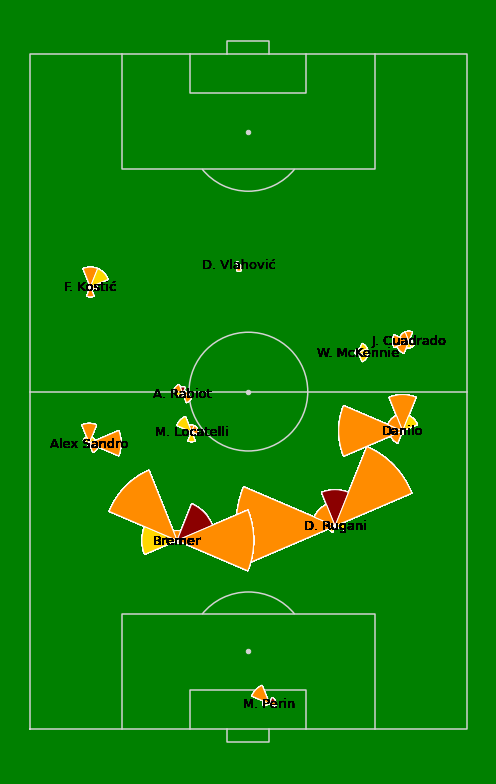

In [79]:
%matplotlib inline

background = "#008000"

fig, ax = plt.subplots(figsize=(7, 11))
fig.set_facecolor(background)

draw_pitch(orientation="v",
           aspect="full",
           pitch_color=background, 
           line_color="lightgrey",
           ax=ax)


ax = fig.add_subplot(111, facecolor=background)
ax.set_xlim(0, pitch_size_width) #Horizontal pitch size 
ax.set_ylim(0, pitch_size_lenght) #Vertical pitch size

for _, player in pass_position.iterrows():
  ax.text(
    player.fromXm
    ,player.fromYm
    ,player.player
    ,fontsize=13
    ,ha='center'
    ,va='center'
    ,color='black'
  )
  
  for _, pass_detail in pass_sonar[pass_sonar.playerId == player.playerId].iterrows():
    #Start degree of direction 1
    theta_left_start = 112.5
    
    #Color coding by distance
    color = 'darkred'
    if pass_detail.distance < 15:
      color = 'gold'
    elif pass_detail.distance < 25:
      color = 'darkorange'
    #Calculate degree in matplotlib figure
    theta_left = theta_left_start - (360 / 8) * (pass_detail.direction - 1)
    theta_right = theta_left - (360 / 8)
    pass_wedge = pat.Wedge(
      center=(player.fromXm, player.fromYm)
      ,r=int(pass_detail.amount)*0.45
      ,theta1=theta_right
      ,theta2=theta_left
      ,facecolor=color
      ,edgecolor='white'
    )
    ax.add_patch(pass_wedge)

ax.axis("off")


plt.tight_layout()
plt.show()